# Path Integrating Recurrent Neural Network

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /Users/facosta/code/pirnns/pirnns
Directory added to path:  /Users/facosta/code/pirnns
Directory added to path:  /Users/facosta/code/pirnns/pirnns


## Define the task datamodule

The datamodule is responsible for loading the training and validation datasets.

This defines the inputs and outputs of the neural computation.

In [88]:
import lightning as L
from torch.utils.data import DataLoader
import torch
import math
from torch.utils.data import TensorDataset


class PathIntegrationDataModule(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        train_val_split: float,
        start_time: float,
        end_time: float,
        num_time_steps: int,
        arena_L: float = 5,
        mu_speed: float = 1,
        sigma_speed: float = 0.5,
        tau_vel: float = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.train_val_split = train_val_split
        self.start_time = start_time
        self.end_time = end_time
        self.num_time_steps = num_time_steps
        self.dt = (end_time - start_time) / num_time_steps

        self.arena_L = arena_L
        self.mu_speed = mu_speed
        self.sigma_speed = sigma_speed
        self.tau_vel = tau_vel

    def _simulate_trajectories(
        self,
        device: str = "cpu",
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates a batch of trajectories following the Ornstein-Uhlenbeck process.
        (Brownian motion with a drift term).

        Parameters
        ----------
        device : str
            The device to use for the simulation.
        Returns
        -------
        x         : (batch, T, 2), [heading, speed] at each time step
        positions : (batch, T, 2), ground-truth (x,y) positions (optional target)
        """
        # --- initial position & velocity ----------------------------------------
        pos = torch.rand(self.batch_size, 2, device=device) * self.arena_L
        # sample initial heading uniformly in (0, 2pi), speed around mu_speed
        hd0 = torch.rand(self.batch_size, device=device) * 2 * torch.pi
        spd0 = torch.clamp(
            torch.randn(self.batch_size, device=device) * self.sigma_speed
            + self.mu_speed,
            min=0.0,
        )
        vel = torch.stack((torch.cos(hd0), torch.sin(hd0)), dim=-1) * spd0.unsqueeze(-1)

        pos_all, vel_all = [pos], [vel]

        sqrt_2dt_over_tau = math.sqrt(2 * self.dt / self.tau_vel)
        for _ in range(self.num_time_steps - 1):
            # OU velocity update (momentum)
            noise = torch.randn_like(vel)
            vel = (
                vel
                + (self.dt / self.tau_vel) * (-vel)
                + self.sigma_speed * sqrt_2dt_over_tau * noise
            )

            # position update
            pos = pos + vel * self.dt

            # --- reflective boundaries -----------------------------------------
            out_left = pos[:, 0] < 0
            out_right = pos[:, 0] > self.arena_L
            out_bottom = pos[:, 1] < 0
            out_top = pos[:, 1] > self.arena_L

            # reflect positions and flip corresponding velocity component
            if out_left.any():
                pos[out_left, 0] *= -1
                vel[out_left, 0] *= -1
            if out_right.any():
                pos[out_right, 0] = 2 * self.arena_L - pos[out_right, 0]
                vel[out_right, 0] *= -1
            if out_bottom.any():
                pos[out_bottom, 1] *= -1
                vel[out_bottom, 1] *= -1
            if out_top.any():
                pos[out_top, 1] = 2 * self.arena_L - pos[out_top, 1]
                vel[out_top, 1] *= -1

            pos_all.append(pos)
            vel_all.append(vel)

        vel_all = torch.stack(vel_all, 1)  # (batch, T, 2)
        pos_all = torch.stack(pos_all, 1)  # (batch, T, 2)
        speeds = torch.linalg.norm(vel_all, dim=-1)
        headings = torch.atan2(vel_all[..., 1], vel_all[..., 0]) % (2 * torch.pi)

        input = torch.stack((headings, speeds), dim=-1)  # (batch, T, 2)
        return input, pos_all

    def setup(self, stage=None) -> None:
        input, target = self._simulate_trajectories(device="cpu")
        self.train_dataset = TensorDataset(input, target)
        self.val_dataset = TensorDataset(input, target)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

Instantiate the datamodule

In [86]:
datamodule = PathIntegrationDataModule(
    batch_size=128,
    train_val_split=0.8,
    start_time=0,
    end_time=100,
    num_time_steps=1000,
    arena_L=5,
    mu_speed=0.2,
    sigma_speed=0.5,
    tau_vel=1,
)
datamodule.setup()

Visualize example trajectory

/var/folders/8b/kfw1m18s7wsbzj2w7s172dxh0000gn/T/ipykernel_77189/3297901368.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_x = speeds * np.cos(head_directions)
/var/folders/8b/kfw1m18s7wsbzj2w7s172dxh0000gn/T/ipykernel_77189/3297901368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_y = speeds * np.sin(head_directions)


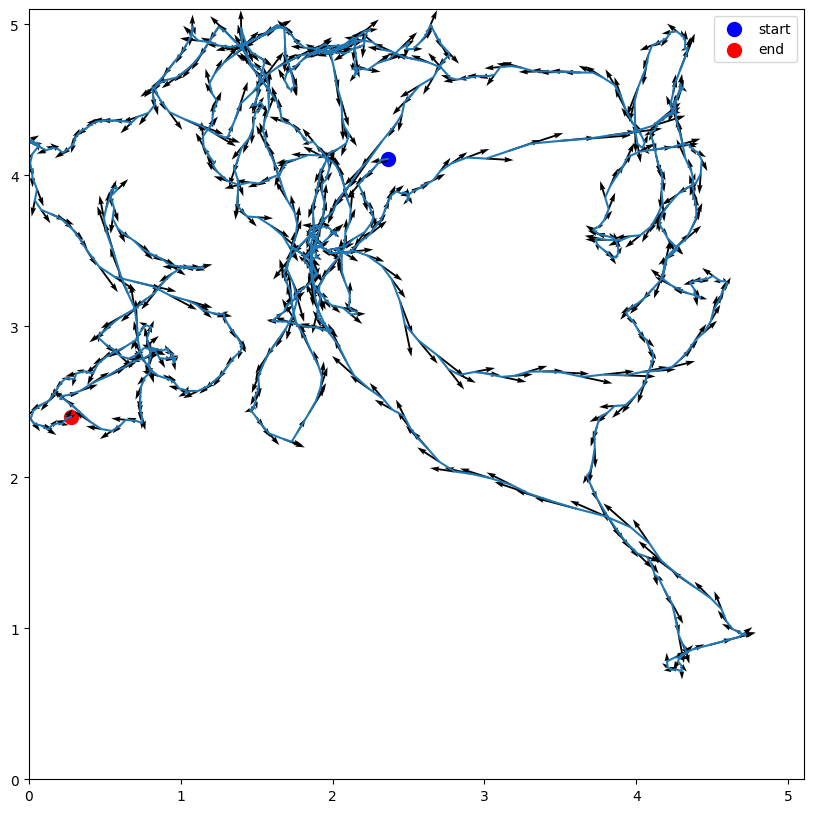

In [87]:
import numpy as np
import matplotlib.pyplot as plt

loader = datamodule.train_dataloader()
batch_inputs, batch_positions = next(iter(loader))

positions = batch_positions[0, :, :]

head_directions = batch_inputs[0, :, 0]
speeds = batch_inputs[0, :, 1]

v_x = speeds * np.cos(head_directions)
v_y = speeds * np.sin(head_directions)


plt.figure(figsize=(10, 10))
# set limits
plt.xlim(0, 5.1)
plt.ylim(0, 5.1)

# plot start and end points
plt.scatter(positions[0, 0], positions[0, 1], color="blue", label="start", s=100)
plt.scatter(positions[-1, 0], positions[-1, 1], color="red", label="end", s=100)
plt.legend()

# plot trajectories
plt.plot(positions[:, 0], positions[:, 1])

# plot velocity vectors
plt.quiver(positions[:, 0], positions[:, 1], v_x, v_y)
plt.show()

## Define the model to be trained on the task

In [5]:
import torch
import torch.nn as nn

class PIRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(PIRNN, self).__init__()
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.output_size: int = output_size
        self.alpha: float = 0.1

        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_rec = nn.Linear(hidden_size, hidden_size)
        self.W_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h) -> tuple[torch.Tensor, torch.Tensor]:
        # x has shape (batch_size, time_steps,input_size)
        # h has shape (batch_size, time_steps hidden_size)
        hidden_states = []
        outputs = []
        for t in range(x.shape[1]):
            h = (1 - self.alpha) * h + self.alpha * torch.tanh(
                self.W_in(x[:, t, :]) + self.W_rec(h)
            )
            hidden_states.append(h)
            outputs.append(self.W_out(h))
        return torch.stack(hidden_states, dim=1), torch.stack(outputs, dim=1)


model = PIRNN(input_size=10, hidden_size=10, output_size=10)

In [6]:
print(model)

PIRNN(
  (W_in): Linear(in_features=10, out_features=10, bias=True)
  (W_rec): Linear(in_features=10, out_features=10, bias=True)
  (W_out): Linear(in_features=10, out_features=10, bias=True)
)


Initialize the weights of the model:

## Instantiate the lightning module and Trainer

The model lightning module is responsible for implementing the training and validation steps.

This involves defining the loss function, the optimizer, and the learning rate scheduler.

The trainer is responsible for training the model.

In [7]:
import lightning as L
import torch.nn as nn


class PIRNNLightning(L.LightningModule):
    def __init__(
        self, model: nn.Module, lr: float = 0.01, num_epochs: int = 100
    ) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.num_epochs = num_epochs

        self.train_losses: list[torch.Tensor] = []
        self.val_losses: list[torch.Tensor] = []

    def training_step(self, batch) -> torch.Tensor:
        input, hidden, target = batch
        hidden_states, outputs = self.model(input, hidden)

        loss = nn.functional.mse_loss(outputs, target)

        self.log("train_loss", loss)

        self.train_losses.append(loss)
        return loss

    def validation_step(self, batch) -> torch.Tensor:
        input, hidden, target = batch
        hidden_states, outputs = self.model(input, hidden)

        loss = nn.functional.mse_loss(outputs, target)

        self.log("val_loss", loss)

        self.val_losses.append(loss)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [11]:
rnn_lightning = PIRNNLightning(model=model, lr=0.01, num_epochs=100)

In [12]:
print(rnn_lightning)

PIRNNLightning(
  (model): PIRNN(
    (W_in): Linear(in_features=10, out_features=10, bias=True)
    (W_rec): Linear(in_features=10, out_features=10, bias=True)
    (W_out): Linear(in_features=10, out_features=10, bias=True)
  )
)


## Train the model

Visualize the training loss, validation loss, and accuracy.

## Analyze the weights & activations